<h1><center>COVID-19 data analysis and predictions</center></h1>

### <font color='green'>https://github.com/bojan-vujic/COVID-19</font>

### All the functions needed in this notebook are stored in files <font color='royalblue'>functions.py</font> and <font color='royalblue'>plots.py</font>
<blockquote>
    
 * <font color='green'> read_data_from_github(`baseURL`, `date_to_process`): </font> reads the data from github

 * <font color='green'>display_data(`TOP_n_countries`, `Recent_n_days`, `pd_dataframe`):</font> displays the data for the given pd_dataframe (confirmed, ...)
 
 * <font color='green'>world_population():</font> returns a pd_dataframe with the population for most of countries
 
 * <font color='green'>get_population_area_and_country_ISO_code(`country`, `population_df`):</font> self explanatory.
 
 * <font color='green'>data_larger_than_min_cases(`country`, `min_cases`, `pd_dataframe`):</font>
 
 * <font color='green'>list_of_countries(`pd_dataframe`):</font> returns a list of countries within a pd_dataframe (confirmed)
</blockquote>

<font color='royalblue'>Use help for a function:</font> it will return a short description.
```python
help(data_larger_than_min_cases)
```


### A logistic function is used to predict number of confirmed cases

### \begin{equation}
    f(x) = \frac{a}{1 + e^{-b (x - c)}} + d
\end{equation}

#### `a`, `b`, `c` and  `d` are constants that are optimized.`

#### In some future extensions, it would be nice to have implemetation of countries population within logistic equation.

### Import some packages and predefined functions

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter

%pylab inline
import scipy
from scipy.optimize import *
from scipy.interpolate import interp1d
%run functions.py
%run plots.py

# My github page hosting the data
baseURL = "https://raw.githubusercontent.com/bojan-vujic/COVID-19/master/Data/"

# Or locally once you setup everything
#baseURL = "CSV_data/Github/"

# date for which data will be processed
d = datetime.datetime.today()
date_to_process = d.strftime('%m-%d-%Y')

#date_to_process = "04-07-2020"
print(date_to_process)

Populating the interactive namespace from numpy and matplotlib
04-08-2020


### Read data from github page

In [2]:
confirmed, recovered, death = read_data_from_github(baseURL, date_to_process)

TOP_n_countries = 3
Recent_n_days   = 3

display_data(TOP_n_countries, Recent_n_days, confirmed)

,04-06-2020,04-07-2020,04-08-2020
Date\Country,,,
World,1341610,1424341,1446879
Europe,703018,743540,752485
US,364013,394587,400549


### Define world population and list of countries

In [3]:
# World population pd_dataframe
csv_url = "https://raw.githubusercontent.com/bojan-vujic/COVID-19/master/World_population.csv"
population = world_population(csv_url)

# list of countries
countries = list_of_countries(confirmed)

# test, print data for Sweden (population, area km2, iso code)
test_country = 'Sweden'
sverige = get_population_area_and_country_ISO_code(test_country, population)
print("country = %s" % test_country + "\npopulation = %i\narea = %i km\u00b2\niso code = %s\n" % sverige)

print(countries[:7])

country = Sweden
population = 10099265
area = 450295 km²
iso code = SE

['World', 'Europe', 'US', 'Spain', 'Italy', 'France', 'Germany']


### Make some directories for the data to be stored

In [4]:
import os

# Create dir "graphs"
name2 = "Graphs"
sub_dir = "Prediction_plots"

try:
    os.makedirs('./%s/%s/%s/' % (name2, date_to_process, sub_dir))
    print('./%s/%s/%s/  : created' % (name2, date_to_process, sub_dir))
except FileExistsError:
    pass


<h1><center>Plot the data</center></h1>

## User input settings

In [5]:
# number of days for which the plot will be made
Last_n_days_country = 4 * 7
World_n_days        = 6 * 7  # used for 'World', 'Europe', 'World-Europe'

# Make predictions for n days
# Any integer starting from zero, 0, 1, ...
predict_for_n_days = 7

# we want at least n_x_ticks on the x axis
# too dense is not readable
# any integer
n_x_ticks = 12

dir_with_daily_rate = "Daily_rate"

# make bar plot
n_x_ticks_rate = 7
Last_n_days_for_rate = 14
fmt = '%b. %d'

# Some of the date formats
# '%b. %d'   = 'Apr. 08'
# '%m %d %Y' = '04 08 2020'
# '%m-%d%y'  = '04-08-20'

# format of x-axis labels ()
x_axis_fmt = '%b. %d'

TOP_n_countries = 3

SCALE = 'lin' # or 'log'

# Output format of saved plot
# 'pdf', 'png', 'jpg'

output_format = 'jpg'
output_dpi    = 220 #applicable only with 'png' or 'jpg' output formats

# Countries that will be displayed within this notebook
countries_to_display = ['World', 'Europe', 'US', 'Sweden', 'Italy', 'Spain', 'Germany', 'France',
                        'United Kingdom', 'Switzerland', 'Netherlands']

make_plot = 'Yes' # any other string is 'No'


## Make some predictions

C:\Users\bojan\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


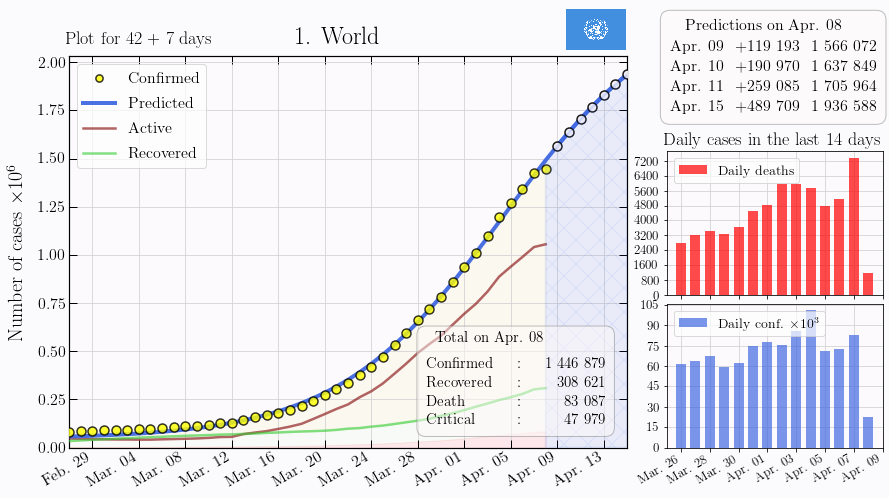

  1 World                : saved to  ./Graphs/04-08-2020/Prediction_plots/World_lin.jpg


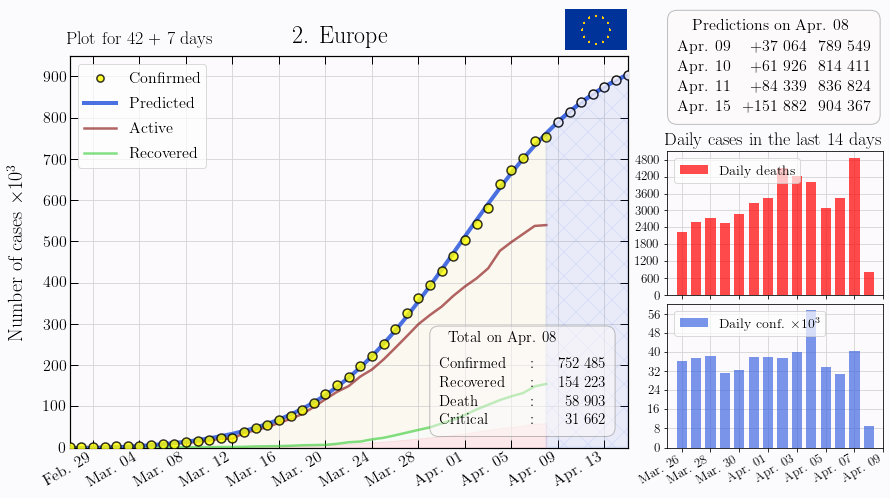

  2 Europe               : saved to  ./Graphs/04-08-2020/Prediction_plots/Europe_lin.jpg


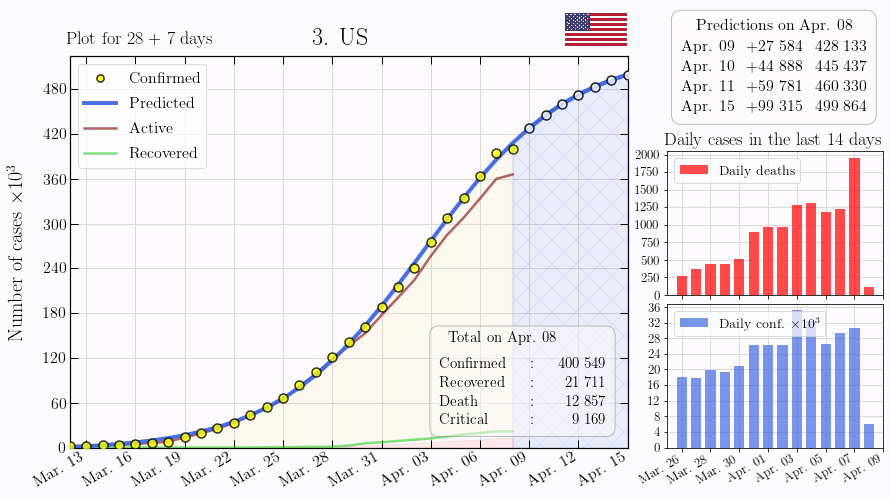

  3 US                   : saved to  ./Graphs/04-08-2020/Prediction_plots/US_lin.jpg


In [6]:
for i in range(len(countries)):
    country = countries[i]
    if i > -1 and i < TOP_n_countries:
        
        Last_n_days = World_n_days if country in ['World', 'Europe'] else Last_n_days_country
        
        opt_params, opt_min = optimal_parameters(i, country, confirmed, recovered, death)
        x_time, x_day, conf_cases = data_gt_or_eq_than_min_cases(country, opt_min, confirmed, recovered, death)[:3]
        
        logistic_x, logistic_y, lg_x, lg_y = logistic_curve(x_time, x_day, predict_for_n_days, *opt_params)
        
        # load data again
        x_time, x_day, conf_cases = get_data_for_last_n_days(country, Last_n_days, confirmed)
        recov_cases  = get_data_for_last_n_days(country, Last_n_days, recovered)[2]
        death_cases  = get_data_for_last_n_days(country, Last_n_days, death)[2]
        active_cases = np.subtract(np.subtract(conf_cases, recov_cases), death_cases)
        
        country_population, country_area, country_iso_code = get_population_area_and_country_ISO_code(country, population)
        delta_conf  = since_one_day_before(country, date_to_process, confirmed, recovered, death)[0]
        x_confirmed, x_recovered, x_death    = conf_rec_dea(country, date_to_process, confirmed, recovered, death)
        image_url = country_image_url(country_iso_code)
        flag_url  = country_flag_url(country_iso_code)
        
        critical  = critical_cases(baseURL, date_to_process, country)
        
        if output_format == 'pdf':
            fig_name = './%s/%s/%s/%i_%s_%s.%s' % (name2, date_to_process, sub_dir, i+1, \
                                               country.replace(" ","_"), SCALE, output_format)
        else:
            fig_name = './%s/%s/%s/%s_%s.%s' % (name2, date_to_process, sub_dir, \
                                               country.replace(" ","_"), SCALE, output_format)
        
        predictions_enabled = 'Yes' if np.max(lg_y) >= np.max(conf_cases)-1 else 'No'
        
        if make_plot == 'Yes':
            try:
                num_add_points = len(lg_y) if predictions_enabled == 'Yes' else 0
                
                total_points = len(conf_cases) + num_add_points
                time_interval = return_time_interval(Last_n_days+num_add_points, n_x_ticks, total_points)
                
                x_time_rate, x_day_rate, conf_cases_rate = \
                                        get_data_for_last_n_days(country, Last_n_days_for_rate+1, confirmed)
                
                death_cases_rate = get_data_for_last_n_days(country, Last_n_days_for_rate+1, death)[2]
                death_cases_rate = return_change_per_day(death_cases_rate)
                
                time_interval_rate = return_time_interval(Last_n_days_for_rate, n_x_ticks_rate, len(conf_cases_rate))
                conf_cases_rate = return_change_per_day(conf_cases_rate)
                time_array = x_time_rate[1:]
                
                make_model_plot(i, country, x_time, conf_cases, recov_cases, death_cases, active_cases, predictions_enabled, \
                                SCALE, country_population, x_confirmed, x_recovered, x_death, critical, Last_n_days, delta_conf,\
                                image_url, countries_to_display, fig_name, time_interval, \
                                logistic_x, logistic_y, predict_for_n_days, fmt, lg_x, lg_y, flag_url, date_to_process, \
                                time_array, time_interval_rate, conf_cases_rate, \
                                death_cases_rate, Last_n_days_for_rate, x_axis_fmt, output_format, output_dpi)
            except:
                pass
            if predictions_enabled == 'Yes':
                print("%3i %-20s : saved to " % (i+1, country), fig_name)
            else:
                print("%3i %-27s : can not make an accurate prediction" % (i+1, country))


### Merge multiple pdf images into a single file

In [ ]:
from PyPDF2 import PdfFileMerger
import os.path

figures = []
for i, country in enumerate(countries):
    fig_name = './%s/%s/%s/%i_%s_%s.pdf' % (name2, date_to_process, sub_dir, i+1, country.replace(" ","_"), SCALE)
    if os.path.exists(fig_name):
        figures.append(str(fig_name))

merger = PdfFileMerger()
for figure in figures:
    merger.append(figure)

merger.write("%s/Predictions_%s_%s.pdf" % (name2, date_to_process, SCALE))
merger.close()